In [1]:
import os
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, gaussian_kde, linregress, ttest_ind, sem, zscore
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from scipy.stats import percentileofscore
from sklearn.utils.validation import check_random_state
from math import factorial
from more_itertools import distinct_permutations
import statsmodels.api as sm

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from tqdm.notebook import tqdm

import warnings
import random
#from torch.utils.data import SubsetRandomSampler
from sklearn.utils import resample

from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score
from collections import Counter

from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")



In [2]:
from scipy.stats import chi2

def summarize_feature(df, feature, df_out, stat_cols=(10, 50), df_offset=2):

    d = df[df["Feature"] == feature]
    if d.empty:
        return df_out  

    for k in stat_cols:
        col = f"hl_statistic_{k}"
        if col in d.columns:
            df_chi = k - df_offset
            combined_p = 1 - chi2.cdf(d[col].mean(), df_chi)
            df_out.loc[feature, f"hl_pvalue_combined_{k}"] = combined_p

    # --- OR summary ---
    if "OR" in d.columns:
        or_mean = d["OR"].mean()
        or_std = d["OR"].std(ddof=1)
        df_out.loc[feature, "OR"] = or_mean
        df_out.loc[feature, "2.5%"] = or_mean - or_std
        df_out.loc[feature, "97.5%"] = or_mean + or_std

    # --- min/max de los IC originales (tal como lo estabas haciendo) ---
    if "2.5%" in d.columns:
        df_out.loc[feature, "minOR"] = d["2.5%"].min()
    if "97.5%" in d.columns:
        df_out.loc[feature, "maxOR"] = d["97.5%"].max()

    return df_out


features = ["Mono", "One", "Two", "Three", "Total"] 




def hosmer_lemeshow(y_true, y_prob, g):
    hl_df = pd.DataFrame({
        "observed": y_true,
        "predicted_probability": y_prob
    }).dropna()


    hl_df["group"] = pd.qcut(hl_df["predicted_probability"], g, duplicates="drop")

    hl_table = hl_df.groupby("group").apply(
        lambda x: pd.Series({
            "observed": x["observed"].sum(),
            "expected": x["predicted_probability"].sum(),
            "total": len(x)
        })
    )

    hl_table["observed_neg"] = hl_table["total"] - hl_table["observed"]
    hl_table["expected_neg"] = hl_table["total"] - hl_table["expected"]


    hl_statistic = (
        ((hl_table["observed"] - hl_table["expected"])**2) / hl_table["expected"] +
        ((hl_table["observed_neg"] - hl_table["expected_neg"])**2) / hl_table["expected_neg"]
    ).sum()


    dof = hl_table.shape[0] - 2
    p_value = 1 - chi2.cdf(hl_statistic, dof)

    return hl_statistic, p_value



def summarize_feature_by_covar(df, covar, feature, df_out, stat_cols=(10, 50), df_offset=2):
    d = df[(df["Covar"] == covar) & (df["Feature"] == feature)]
    if d.empty:
        return df_out

    idx = (covar, feature)

    for k in stat_cols:
        col = f"hl_statistic_{k}"
        if col in d.columns:
            df_chi = k - df_offset
            df_out.loc[idx, f"hl_pvalue_combined_{k}"] = 1 - chi2.cdf(d[col].mean(), df_chi)

    or_mean = d["OR"].mean()
    or_std  = d["OR"].std(ddof=1)
    df_out.loc[idx, "OR"] = or_mean
    df_out.loc[idx, "2.5%"] = or_mean - or_std
    df_out.loc[idx, "97.5%"] = or_mean + or_std

    df_out.loc[idx, "minOR"] = d["2.5%"].min()
    df_out.loc[idx, "maxOR"] = d["97.5%"].max()

    df_out.loc[idx, "n_iter"] = d.shape[0]

    return df_out


# Cross Odds ratios

### Load data

In [3]:
data = pd.read_parquet('data/BBAG-cross.parquet')

In [4]:
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

In [5]:
Counter(data.country)

Counter({'Austria': 4320,
         'Belgium': 4942,
         'Czechia': 5575,
         'Switzerland': 2634,
         'Germany': 4567,
         'Denmark': 2609,
         'Estonia': 7522,
         'Spain': 4912,
         'France': 3640,
         'Hungary': 3010,
         'Italy': 4541,
         'Netherlands': 2546,
         'Poland': 3612,
         'Portugal': 1914,
         'Sweden': 2792,
         'Slovenia': 5291,
         'Luxembourg': 2104,
         'Greece': 2599,
         'Croatia': 2798,
         'Bulgaria': 1953,
         'Cyprus': 1205,
         'Finland': 1982,
         'Lithuania': 2033,
         'Latvia': 1684,
         'Malta': 1259,
         'Romania': 2083})

In [6]:
vars_ = ['Mono', 'One',	'Two',	'Three', 'Total']


In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

vars_ = ['Mono', 'One', 'Two', 'Three', 'Total']

# Data
results_merge_df_all = data.copy()
results_merge_df_all = results_merge_df_all.loc[:, ~results_merge_df_all.columns.duplicated()]

# Params to iterate
seeds = list(range(0, 101))   # 0..100 inclusive
test_sizes = [0.1, 0.2, 0.3]

rows = []

for feature in vars_:
    display(feature)
    # Keep only rows with y and this feature available
    d = results_merge_df_all[[feature, 'GAP_bin']].dropna().copy()
    y = d['GAP_bin'].astype(int)

    for seed in seeds:
        for test_size in test_sizes:
            X = d[[feature]].astype(float)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=seed
            )

            # Scale (fixed)
            scaler = MinMaxScaler(feature_range=(0.05, 0.95))
            X_train_scaled = pd.DataFrame(
                scaler.fit_transform(X_train),
                columns=X_train.columns,
                index=X_train.index
            )

            # Add intercept
            X_train_scaled['intercept'] = 1

            # Fit
            try:
                model = sm.Logit(y_train, X_train_scaled).fit(disp=0)

                params = model.params
                ci = model.conf_int()
                ci_exp = np.exp(ci)
                or_ = np.exp(params)

                rows.append({
                    "Feature": feature,
                    "seed": seed,
                    "test_size": test_size,
                    "OR": float(or_[feature]),
                    "2.5%": float(ci_exp.loc[feature, 0]),
                    "97.5%": float(ci_exp.loc[feature, 1]),
                    "z": float(model.tvalues[feature]),
                    "P>|z|": float(model.pvalues[feature]),
                    "n_train": int(X_train_scaled.shape[0]),
                    "n_total": int(d.shape[0]),
                })

            except Exception as e:
                # If a fit fails for some split/seed, keep a record (optional)
                rows.append({
                    "Feature": feature,
                    "seed": seed,
                    "test_size": test_size,
                    "OR": np.nan,
                    "2.5%": np.nan,
                    "97.5%": np.nan,
                    "z": np.nan,
                    "P>|z|": np.nan,
                    "n_train": int(X_train.shape[0]),
                    "n_total": int(d.shape[0]),
                    "error": str(e),
                })

df_directions_odd = pd.DataFrame(rows)

# Nice column order
cols_first = ["Feature", "seed", "test_size", "OR", "2.5%", "97.5%", "z", "P>|z|", "n_train", "n_total"]
other_cols = [c for c in df_directions_odd.columns if c not in cols_first]
df_directions_odd = df_directions_odd[cols_first + other_cols]

# Save
out_path = "Results/cross/cross_OR_-removing-slovakia_seeds0-100_testsizes0.1-0.3.xlsx"
df_directions_odd.to_excel(out_path, index=False)

df_directions_odd


'Mono'

'One'

'Two'

'Three'

'Total'

,Feature,seed,test_size,OR,2.5%,97.5%,z,P>|z|,n_train,n_total
0,Mono,0,0.1,2.113399,1.993037,2.241031,25.011644,4.567023e-138,75714,84127
1,Mono,0,0.2,2.119155,1.991151,2.255389,23.625299,2.118488e-123,67301,84127
2,Mono,0,0.3,2.159429,2.020200,2.308253,22.639530,1.769195e-113,58888,84127
3,Mono,1,0.1,2.112583,1.992371,2.240048,25.021000,3.612590e-138,75714,84127
4,Mono,1,0.2,2.138561,2.009776,2.275598,23.987021,3.798751e-127,67301,84127
...,...,...,...,...,...,...,...,...,...,...
1510,Total,99,0.2,0.471471,0.443068,0.501694,-23.718192,2.340645e-124,67301,84127
1511,Total,99,0.3,0.466724,0.436748,0.498757,-22.499139,4.231955e-112,58888,84127
1512,Total,100,0.1,0.470080,0.443302,0.498474,-25.225596,2.098771e-140,75714,84127
1513,Total,100,0.2,0.474066,0.445501,0.504463,-23.539730,1.599432e-122,67301,84127


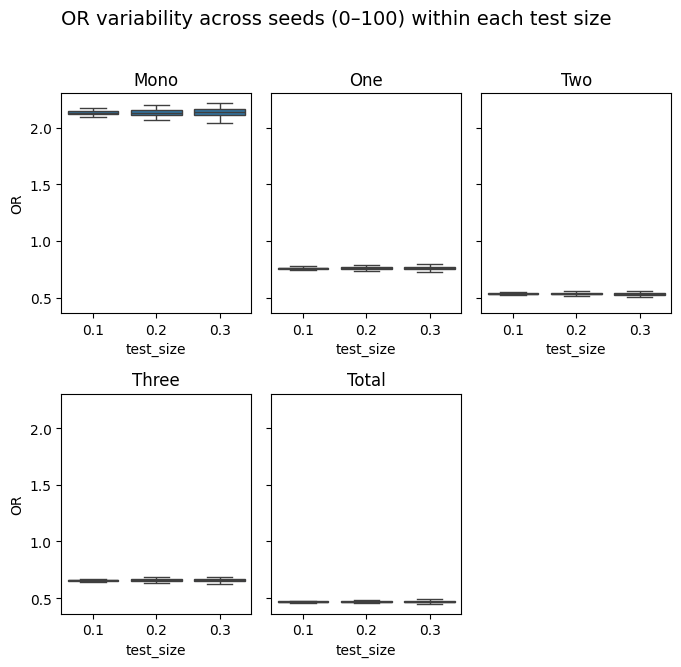

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_directions_odd.copy()

features = ['Mono', 'One', 'Two', 'Three', 'Total']
test_order = [0.1, 0.2, 0.3]

# 2x3 grid for 5 features (one empty)
fig, axes = plt.subplots(2, 3, figsize=(7, 6.5), sharey=True)
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    d = df[df["Feature"] == feature].copy()

    sns.boxplot(
        data=d,
        x="test_size",
        y="OR",
        order=test_order,
        showfliers=False,
        ax=ax
    )

    #ax.axhline(1, linestyle="--", linewidth=1, color="black")
    ax.set_title(feature)
    ax.set_xlabel("test_size")
    ax.set_ylabel("OR" if idx % 3 == 0 else "")

# Hide the last unused subplot (6th)
for j in range(len(features), len(axes)):
    axes[j].axis("off")

fig.suptitle("OR variability across seeds (0–100) within each test size", y=1.02, fontsize=14)
plt.tight_layout()

plt.savefig("Figures_pdf/OR_varaibility.pdf", format="pdf", bbox_inches="tight")

plt.show()


# Longitudinal Relative Risk

### Load data

In [9]:
data = pd.read_parquet('data/BBAG-long.parquet')

In [10]:
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

In [11]:
Counter(data.country)

Counter({'Austria': 4320,
         'Belgium': 4942,
         'Czechia': 5575,
         'Switzerland': 2634,
         'Germany': 4567,
         'Denmark': 2609,
         'Estonia': 7522,
         'Spain': 4912,
         'France': 3640,
         'Hungary': 3010,
         'Italy': 4541,
         'Netherlands': 2546,
         'Poland': 3612,
         'Portugal': 1914,
         'Sweden': 2792,
         'Slovenia': 5291,
         'Luxembourg': 2104,
         'Greece': 2599,
         'Croatia': 2798,
         'Bulgaria': 1953,
         'Cyprus': 1205,
         'Finland': 1982,
         'Lithuania': 2033,
         'Latvia': 1684,
         'Malta': 1259,
         'Romania': 2083})

In [12]:
vars_ = ['Mono', 'One',	'Two',	'Three', 'Total']


In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

vars_ = ['Mono', 'One', 'Two', 'Three', 'Total']

# Data
results_merge_df_all = data.copy()
results_merge_df_all = results_merge_df_all.loc[:, ~results_merge_df_all.columns.duplicated()]

# Params to iterate
seeds = list(range(0, 101))   # 0..100 inclusive
test_sizes = [0.1, 0.2, 0.3]

rows = []

for feature in vars_:
    display(feature)
    # Keep only rows with y and this feature available
    d = results_merge_df_all[[feature, 'GAP_bin', 'delta_time']].dropna().copy()
    y = d['GAP_bin'].astype(int)

    for seed in seeds:
        for test_size in test_sizes:
            X = d[[feature] + ['delta_time']].astype(float)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=seed
            )

            # Scale (fixed)
            scaler = MinMaxScaler(feature_range=(0.05, 0.95))
            X_train_scaled = pd.DataFrame(
                scaler.fit_transform(X_train),
                columns=X_train.columns,
                index=X_train.index
            )

            # Add intercept
            X_train_scaled['intercept'] = 1

            # Fit
            try:
                model = sm.GLM(y_train, X_train_scaled, family=sm.families.Binomial(link=sm.families.links.log())).fit(disp = 0)

                params = model.params
                ci = model.conf_int()
                ci_exp = np.exp(ci)
                rr_ = np.exp(params)

                rows.append({
                    "Feature": feature,
                    "seed": seed,
                    "test_size": test_size,
                    "RR": float(rr_[feature]),
                    "2.5%": float(ci_exp.loc[feature, 0]),
                    "97.5%": float(ci_exp.loc[feature, 1]),
                    "z": float(model.tvalues[feature]),
                    "P>|z|": float(model.pvalues[feature]),
                    "n_train": int(X_train_scaled.shape[0]),
                    "n_total": int(d.shape[0]),
                })

            except Exception as e:
                # If a fit fails for some split/seed, keep a record (optional)
                rows.append({
                    "Feature": feature,
                    "seed": seed,
                    "test_size": test_size,
                    "RR": np.nan,
                    "2.5%": np.nan,
                    "97.5%": np.nan,
                    "z": np.nan,
                    "P>|z|": np.nan,
                    "n_train": int(X_train.shape[0]),
                    "n_total": int(d.shape[0]),
                    "error": str(e),
                })

df_directions_odd = pd.DataFrame(rows)

# Nice column order
cols_first = ["Feature", "seed", "test_size", "RR", "2.5%", "97.5%", "z", "P>|z|", "n_train", "n_total"]
other_cols = [c for c in df_directions_odd.columns if c not in cols_first]
df_directions_odd = df_directions_odd[cols_first + other_cols]

# Save
out_path = "Results/long/long_RR_-removing-slovakia_seeds0-100_testsizes0.1-0.3.xlsx"
df_directions_odd.to_excel(out_path, index=False)

df_directions_odd


'Mono'

'One'

'Two'

'Three'

'Total'

,Feature,seed,test_size,RR,2.5%,97.5%,z,P>|z|,n_train,n_total
0,Mono,0,0.1,1.423048,1.378179,1.469378,21.582878,2.601619e-103,75714,84127
1,Mono,0,0.2,1.428576,1.380613,1.478205,20.470482,3.946975e-93,67301,84127
2,Mono,0,0.3,1.441742,1.390146,1.495252,19.676093,3.456433e-86,58888,84127
3,Mono,1,0.1,1.416826,1.372050,1.463063,21.265069,2.391411e-100,75714,84127
4,Mono,1,0.2,1.422700,1.375137,1.471909,20.321654,8.274199e-92,67301,84127
...,...,...,...,...,...,...,...,...,...,...
1510,Total,99,0.2,0.706701,0.683054,0.731168,-19.991322,6.553582e-89,67301,84127
1511,Total,99,0.3,0.703113,0.677980,0.729178,-18.965915,3.262977e-80,58888,84127
1512,Total,100,0.1,0.698829,0.676749,0.721630,-21.876064,4.391457e-106,75714,84127
1513,Total,100,0.2,0.701342,0.677859,0.725640,-20.416035,1.204538e-92,67301,84127


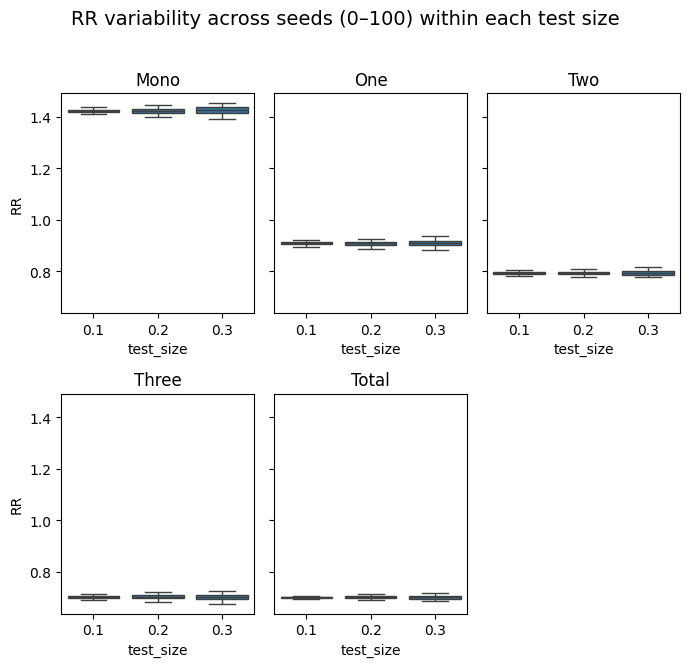

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_directions_odd.copy()

features = ['Mono', 'One', 'Two', 'Three', 'Total']
test_order = [0.1, 0.2, 0.3]

# 2x3 grid for 5 features (one empty)
fig, axes = plt.subplots(2, 3, figsize=(7, 6.5), sharey=True)
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    d = df[df["Feature"] == feature].copy()

    sns.boxplot(
        data=d,
        x="test_size",
        y="RR",
        order=test_order,
        showfliers=False,
        ax=ax
    )

    #ax.axhline(1, linestyle="--", linewidth=1, color="black")
    ax.set_title(feature)
    ax.set_xlabel("test_size")
    ax.set_ylabel("RR" if idx % 3 == 0 else "")

# Hide the last unused subplot (6th)
for j in range(len(features), len(axes)):
    axes[j].axis("off")

fig.suptitle("RR variability across seeds (0–100) within each test size", y=1.02, fontsize=14)
plt.tight_layout()

plt.savefig("Figures_pdf/RR_varaibility.pdf", format="pdf", bbox_inches="tight")

plt.show()
